In [84]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

In [2]:
# Read the data
data = pd.read_csv('orders_autumn_2020.csv', index_col=0)

In [3]:
# Change timestamp to datetime
data.index = pd.to_datetime(data.index)

In [4]:
# Add column to represent weekends to the dataset
data['WEEKEND'] = (data.index.weekday >= 5) * 1

In [5]:
# Helper method to plot correlation matrices
def corr_matrix(data, title):
    corr = data.corr()
    ax = sns.heatmap(
        corr,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    plt.title(title)
    plt.show()

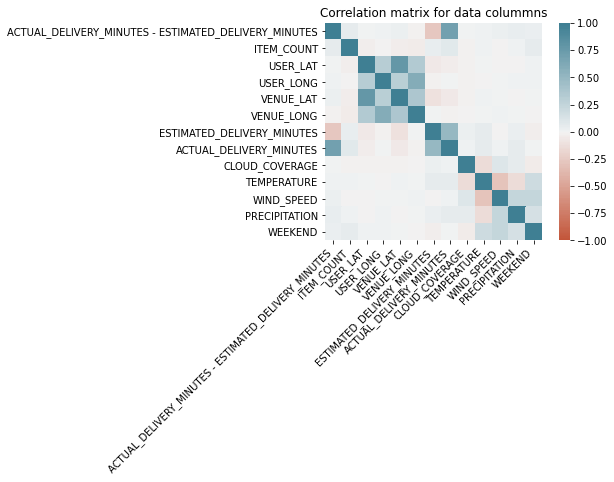

In [6]:
# Create a correlation matrix to find interesting correlations between columns
corr_matrix(data, 'Correlation matrix for data colummns')

In [7]:
##############################
# Nothing unusual to see yet #
##############################

In [23]:
# Clean data and count daily orders and averages
cleaned_data = data.copy()
cleaned_data = cleaned_data.drop(['ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES',
                                    'ESTIMATED_DELIVERY_MINUTES', 'USER_LAT', 'USER_LONG',
                                    'VENUE_LAT', 'VENUE_LONG'], axis=1)
cleaned_data['ORDER_COUNT'] = 1
hourly_average = cleaned_data.groupby(pd.Grouper(level='TIMESTAMP', freq="1H"))\
    .agg({'ITEM_COUNT': 'mean', 'ORDER_COUNT': 'sum', 'ACTUAL_DELIVERY_MINUTES': 'mean', 'CLOUD_COVERAGE': 'mean',
          'TEMPERATURE': 'mean', 'WIND_SPEED': 'mean', 'PRECIPITATION': 'mean', 'WEEKEND': 'mean'})
daily_average = cleaned_data.groupby(pd.Grouper(level='TIMESTAMP', freq="1D"))\
    .agg({'ITEM_COUNT': 'mean', 'ORDER_COUNT': 'sum', 'ACTUAL_DELIVERY_MINUTES': 'mean', 'CLOUD_COVERAGE': 'mean',
          'TEMPERATURE': 'mean', 'WIND_SPEED': 'mean', 'PRECIPITATION': 'mean', 'WEEKEND': 'mean'})

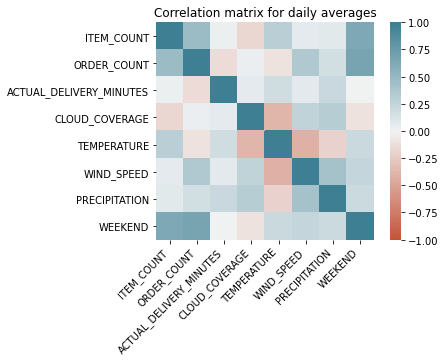

In [24]:
# Plot correlation between daily data
corr_matrix(daily_average, "Correlation matrix for daily averages")

In [25]:
####################################################################################
# We can already see some correlation between WEEKEND and ITEM_COUNT, ORDER_COUNT #
####################################################################################

In [13]:
# Helper function to highlight weekends
def highlight_weekends(dataframe):
    i = 0
    while i < len(dataframe):
        if(dataframe.index.weekday[i] >= 5):
            plt.axvspan(dataframe.index[i], dataframe.index[i+1], facecolor='green', alpha=.15)
        i += 1

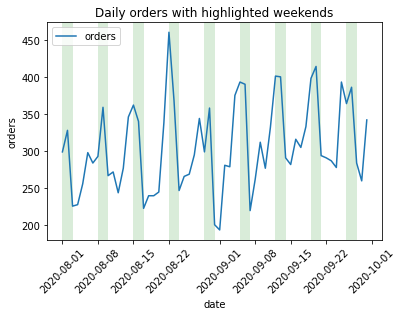

In [27]:
# Highlight weekends and plot graph
highlight_weekends(daily_average)
plt.title('Daily orders with highlighted weekends')
plt.xlabel('date')
plt.ylabel('orders')
plt.xticks(rotation=45)
plt.plot(daily_average.index, daily_average['ORDER_COUNT'], label="orders")
plt.legend(loc="upper left")
plt.show()

In [28]:
#############################
# Clear seasonality visible #
#############################

In [128]:
# Predict future orders with facebook's open source Prophet module using hourly averages
# The Prophet module is based on an additive model and works best for
# predicting time series data with clear seasonality such as Wolt's order data

# Clean and split data for time series prediction
sales = hourly_average.reset_index()
sales = sales[['TIMESTAMP', 'ORDER_COUNT']]
sales.columns = ['ds', 'y']
testsize = int(len(sales)*0.2)
train = sales.drop(sales.index[-testsize:])
test = sales[-testsize:]

In [122]:
# Define model with daily seasonality
model = Prophet(daily_seasonality=True, yearly_seasonality=False)
model.fit(train)

In [123]:
# Make a prediction
pred = model.predict(test)

In [124]:
# Calculate MSE
y_true = test['y'].values
y_pred = pred['yhat'].values
mse = mean_squared_error(y_true, y_pred)
print("MSE: %.2f" % mse)

MSE: 32.66


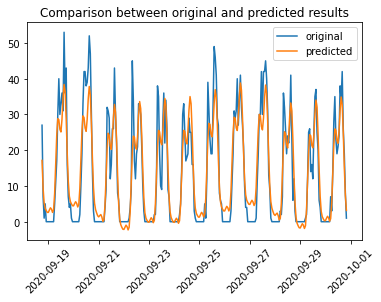

In [125]:
# Plot results
plt.title("Comparison between original and predicted results")
plt.xticks(rotation=45)
plt.plot(test['ds'], y_true, label="original")
plt.plot(test['ds'], y_pred, label="predicted")
plt.legend()
plt.show()

In [126]:
# Future out of data prediction one week ahead
dates= pd.date_range("2020-10-1 00:00", "2020-10-7 23:59", freq="60min")
future = pd.DataFrame(dates)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])
forecast = model.predict(future)
future_pred = forecast['yhat'].values
future['Orders'] = future_pred
future.columns = ['Date', 'Orders']

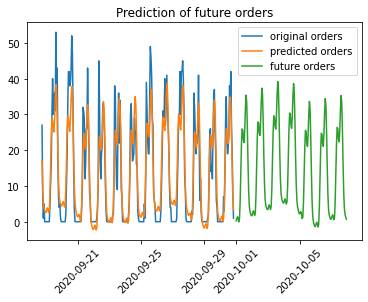

In [127]:
# Plot future predictions next to in data predictions
plt.plot(test['ds'], y_true, label="original orders")
plt.plot(test['ds'], y_pred, label="predicted orders")
plt.plot(future['Date'], future_pred, label="future orders")
plt.title("Prediction of future orders")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()